In [18]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import re
import seaborn as sns
sns.set()
plt.style.use('seaborn-white')
sns.set_context('talk')
sns.set_style('whitegrid', {'grid.linestyle': 'dotted'})

In [2]:
log_directory = '../../../data/raw/logs/'

In [3]:
def get_log_files(dir_path, pattern):
    result = []
    for filename in os.listdir(dir_path):
        res = re.search(pattern, filename)
        if res:
            data_size = res.group(1)
            segment_count = res.group(2)
            rate_limit = res.group(3)
            if data_size:
                result.append((data_size, segment_count, rate_limit, dir_path + "/" + filename))
    return result

In [4]:
def get_kafka_files(dir_path, pattern):
    result = []
    for filename in os.listdir(dir_path):
        res = re.search(pattern, filename)
        if res:
            data_size = res.group(1)
            rate_limit = res.group(2)
            if data_size:
                result.append((data_size, rate_limit,  dir_path + "/" + filename))
    return result

In [5]:
def get_consumer_files(dir_path, pattern):
    result = []
    for filename in os.listdir(dir_path):
        res = re.search(pattern, filename)
        if res:
            data_size = res.group(1)
            if data_size:
                result.append((data_size, dir_path + "/" + filename))
    return result

In [6]:
def create_kafka_producer_dataframe(log_files, skiprows=0):
    joined_df = pd.DataFrame()
    for data_size, rate_limit, filename in log_files:
        df  = pd.read_csv(filename, sep='\t', skiprows=skiprows)
        df.reset_index(inplace=True)
        df["Message Size"] = int(data_size)
        df["Rate Limit in MB/s"] = int(rate_limit) // (1000 * 1000)
        joined_df = pd.concat([joined_df, df])
    return joined_df

In [7]:
def create_rembrandt_dataframe(log_files, skiprows=0):
    joined_df = pd.DataFrame()
    for data_size, segment_count, rate_limit, filename in log_files:
        df  = pd.read_csv(filename, sep='\t', skiprows=skiprows)
        df.reset_index(inplace=True)
        df["Message Size"] = int(data_size)
        df["# of Segments"] = int(segment_count)
        df["Rate Limit in MB/s"] = int(rate_limit) // (1000 * 1000)
        joined_df = pd.concat([joined_df, df])
    return joined_df

In [8]:
def producer_dfs(directory):
    result = {}
    for variant in ["exclusive", "exclusive_opt", "concurrent", "concurrent_opt/10"]:
        variant_dfs = {}
        variant_dfs["tp"] = create_rembrandt_dataframe(get_log_files(directory + variant, "rembrandt_producer_(\d+)_(\d+)_(\d+)_throughput.csv"))
        variant_dfs["event"] = create_rembrandt_dataframe(get_log_files(directory + variant, "rembrandt_producer_(\d+)_(\d+)_(\d+)_event_latency_timeline.csv"), skiprows=1)
        variant_dfs["processing"] = create_rembrandt_dataframe(get_log_files(directory + variant, "rembrandt_producer_(\d+)_(\d+)_(\d+)_processing_latency_timeline.csv"), skiprows=1)
        result[variant] = variant_dfs
    kafka_dfs = {}
    kafka_dfs["tp"] = create_kafka_producer_dataframe(get_kafka_files(directory + "kafka", "kafka_producer_(\d+)_(\d+)_throughput.csv"))
    kafka_dfs["event"] = create_kafka_producer_dataframe(get_kafka_files(directory + "kafka", "kafka_producer_(\d+)_(\d+)_event_latency_timeline.csv"), skiprows=1)
    kafka_dfs["processing"] = create_kafka_producer_dataframe(get_kafka_files(directory + "kafka", "kafka_producer_(\d+)_(\d+)_processing_latency_timeline.csv"), skiprows=1)
    result["kafka"] = kafka_dfs
    return result

In [9]:
def plot_timeseries(dataframe, column):
    fig_dims = (18, 12)
    fig, ax = plt.subplots(figsize=fig_dims)
    sns.set(font_scale=2)
    df = dataframe.pivot(index='index', columns='Rate Limit in MB/s', values=column)
    df.plot(ax=ax)
#     sns.lineplot(x="index", y=column, data=dataframe, hue="Rate Limit in MB/s", ax=ax, legend="full")

# Identify sustainable throughput

## Kafka Sustainable Throughput

In [10]:
dataframes = producer_dfs(log_directory + "20200727/processing_latency/")

In [11]:
dataframes["kafka"]["event"].groupby("Rate Limit in MB/s").mean()

,index,Latency in us,Message Size
Rate Limit in MB/s,,,
240,305175.0,277205.739673,131072.0


In [12]:
kafka_event_df = dataframes["kafka"]["event"][dataframes["kafka"]["event"]["Rate Limit in MB/s"] <= 2400]

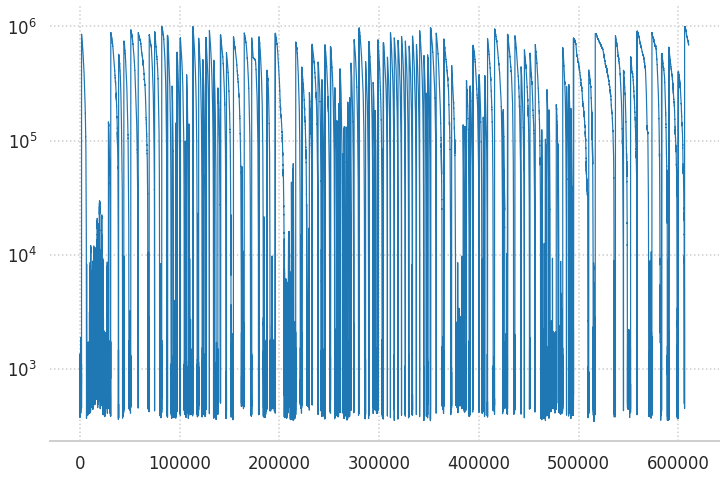

In [15]:
fig_dims = (12, 8)
fig, ax = plt.subplots(figsize=fig_dims)
# sns.set(font_scale=2)
sns.set_context('paper')
sns.set_style('whitegrid', {'grid.linestyle': 'dotted'})
sns.despine(left=True)
# df = dataframes["exclusive"]["processing"][dataframes["exclusive"]["processing"]["Rate Limit in MB/s"] == 3600].pivot(index='index', columns='Rate Limit in MB/s', values="Avg. Latency in us")
ax.plot(kafka_event_df["index"], kafka_event_df["Latency in us"])
plt.yscale("log")
# plt.savefig("exclusive_75_event_timeline")

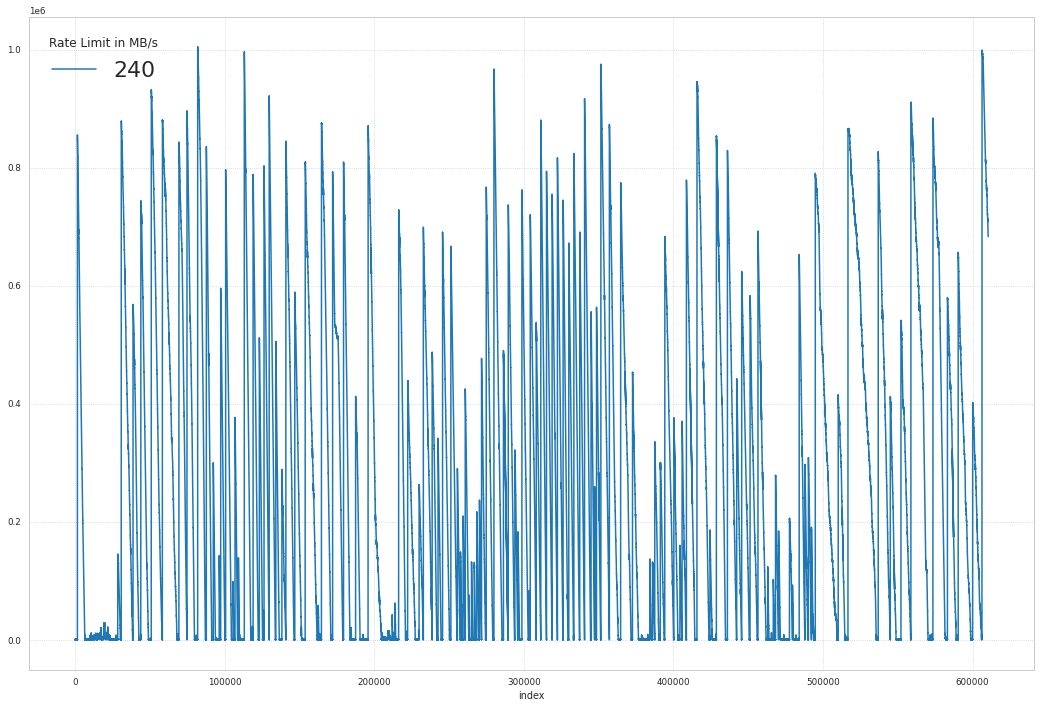

In [64]:
plot_timeseries(dataframes["kafka"]["event"][dataframes["kafka"]["event"]["Rate Limit in MB/s"] <= 240], "Latency in us")

## Ghostwriter Sustainable Throughput

In [13]:
dataframes = producer_dfs(log_directory + "20200727/processing_latency/")

In [14]:
dataframes["exclusive"]["event"].head()

,index,Latency in us,Message Size,# of Segments,Rate Limit in MB/s
0,0,64,131072,90,3800
1,1,50,131072,90,3800
2,2,82,131072,90,3800
3,3,111,131072,90,3800
4,4,136,131072,90,3800


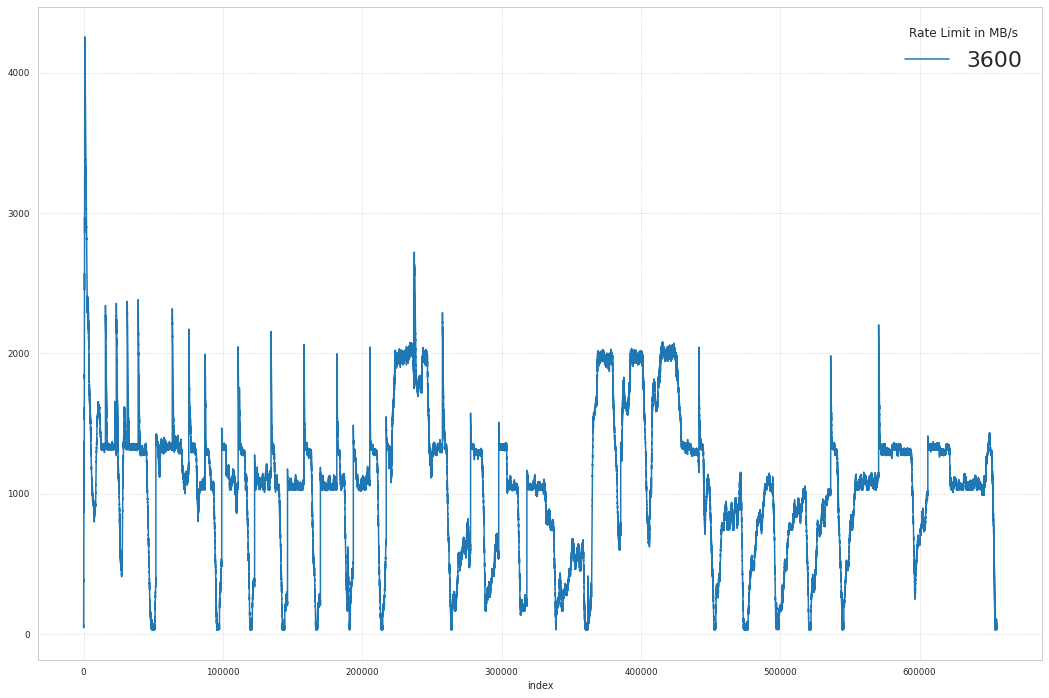

In [18]:
plot_timeseries(dataframes["exclusive"]["event"][dataframes["exclusive"]["event"]["Rate Limit in MB/s"] <= 3600], "Latency in us")

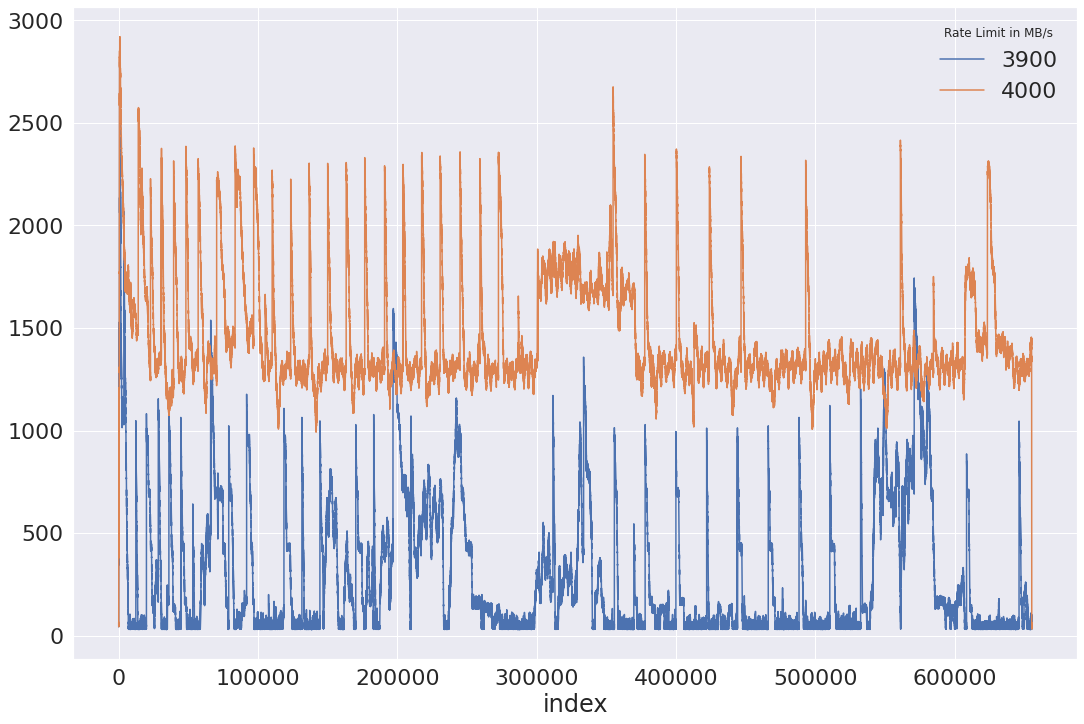

In [19]:
plot_timeseries(dataframes["exclusive_opt"]["event"][dataframes["exclusive_opt"]["event"]["Rate Limit in MB/s"] <= 4000], "Latency in us")

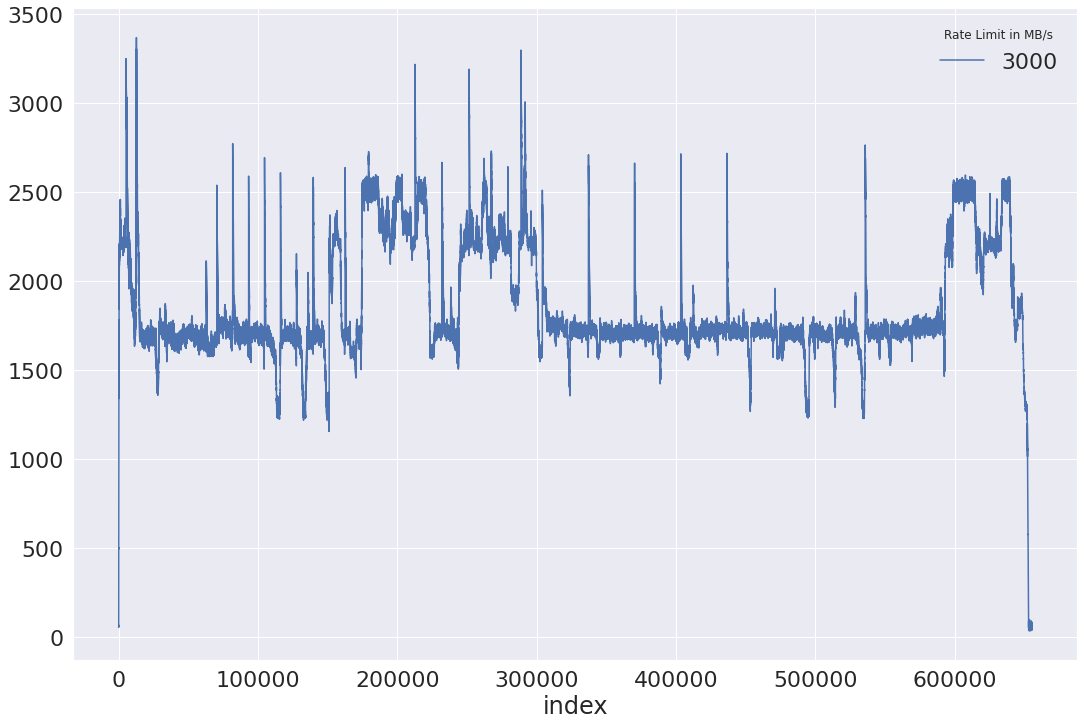

In [20]:
plot_timeseries(dataframes["concurrent"]["event"][dataframes["concurrent"]["event"]["Rate Limit in MB/s"] <= 3000], "Latency in us")

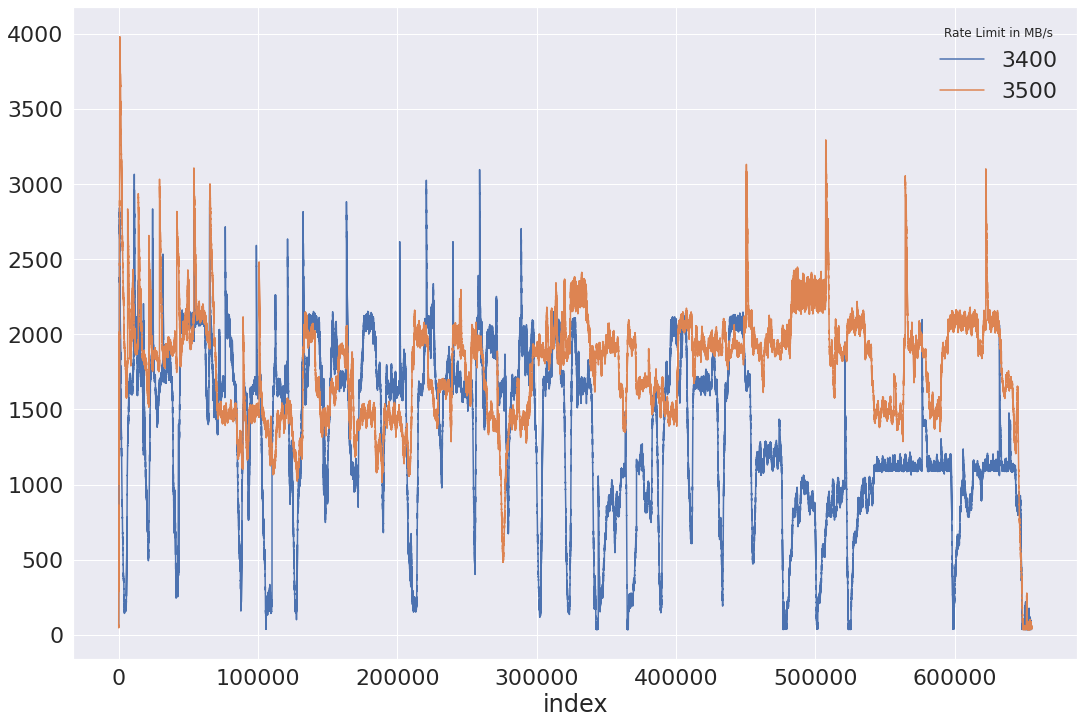

In [21]:
plot_timeseries(dataframes["concurrent_opt/10"]["event"][dataframes["concurrent_opt/10"]["event"]["Rate Limit in MB/s"] <= 3500], "Latency in us")

In [15]:
def filter_dfs(dataframes, measure):
    df_list = [dataframes["exclusive"][measure][dataframes["exclusive"][measure]["Rate Limit in MB/s"] == 3600],
               dataframes["exclusive_opt"][measure][dataframes["exclusive_opt"][measure]["Rate Limit in MB/s"] == 4000],
               dataframes["concurrent"][measure][dataframes["concurrent"][measure]["Rate Limit in MB/s"] == 3000],
               dataframes["concurrent_opt/10"][measure][dataframes["concurrent_opt/10"][measure]["Rate Limit in MB/s"] == 3500],
               dataframes["kafka"][measure][dataframes["kafka"][measure]["Rate Limit in MB/s"] == 240]]
    df_list[0]["Protocol"] = "Excl."
    df_list[1]["Protocol"] = "Excl. Opt."
    df_list[2]["Protocol"] = "Conc."
    df_list[3]["Protocol"] = "Conc. Opt."
    df_list[4]["Protocol"] = "Kafka"
    return pd.concat(df_list)

In [16]:
max_sust_tps_df = filter_dfs(dataframes, "tp")

<ipython-input-15-85779e0d3f1d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_list[0]["Protocol"] = "Excl."
<ipython-input-15-85779e0d3f1d>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_list[1]["Protocol"] = "Excl. Opt."
<ipython-input-15-85779e0d3f1d>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

In [15]:
for label, dataframe in producer_dfs.items():
    dataframe["Broker"] = label
df = pd.concat(producer_dfs.values())
fig, ax = plt.subplots()
sns.despine(left=True)
baseline = ucx_df[ucx_df["operation"] == "PUT"]
baseline = baseline[baseline["message_size"] >= 8192]
g = sns.lineplot(x="Message Size", y="Number of Messages", hue="Broker", style="Broker", data=df, ax=ax,ci="sd", markers=True, dashes=False)
plt.plot(baseline["message_size"], baseline["avg_mr"], color='black', ls=':', marker=".",label="PUT")
g.set_ylabel("Message Rate (messages/s)")
ax.set_xscale('log')
g.set_xticks([8192, 32768, 131072, 524288, 2097152, 8388608])
g.set_xticklabels(['8KiB', '32KiB','128KiB','512KiB', '2MiB', '8MiB'])
g.set(ylim=(0, 100000))
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:],fontsize='x-small')
fig.savefig("ghostwriter_producer_message_rate.pdf", bbox_inches="tight", dpi=600)

AttributeError: 'function' object has no attribute 'items'

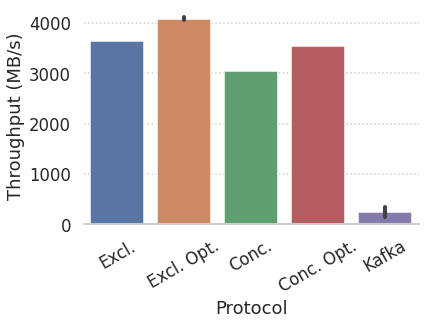

In [19]:
g = sns.barplot(x="Protocol", y="Throughput in MB/s", hue="Protocol", data=max_sust_tps_df, ci="sd", dodge=False)
sns.despine(left=True)
g.get_legend().remove()
g.set_xticklabels(g.get_xticklabels(), rotation=30, horizontalalignment='center')
g.set_ylabel("Throughput (MB/s)")
g.get_figure().savefig("ghostwriter_sustainable_throughput.pdf", bbox_inches="tight", dpi=600)

In [20]:
max_event_lat_df = filter_dfs(dataframes, "event")
max_event_lat_df.head()

<ipython-input-15-85779e0d3f1d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_list[0]["Protocol"] = "Excl."
<ipython-input-15-85779e0d3f1d>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_list[1]["Protocol"] = "Excl. Opt."
<ipython-input-15-85779e0d3f1d>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

,index,Latency in us,Message Size,# of Segments,Rate Limit in MB/s,Protocol
0,0,74,131072,90.0,3600,Excl.
1,1,47,131072,90.0,3600,Excl.
2,2,87,131072,90.0,3600,Excl.
3,3,105,131072,90.0,3600,Excl.
4,4,125,131072,90.0,3600,Excl.


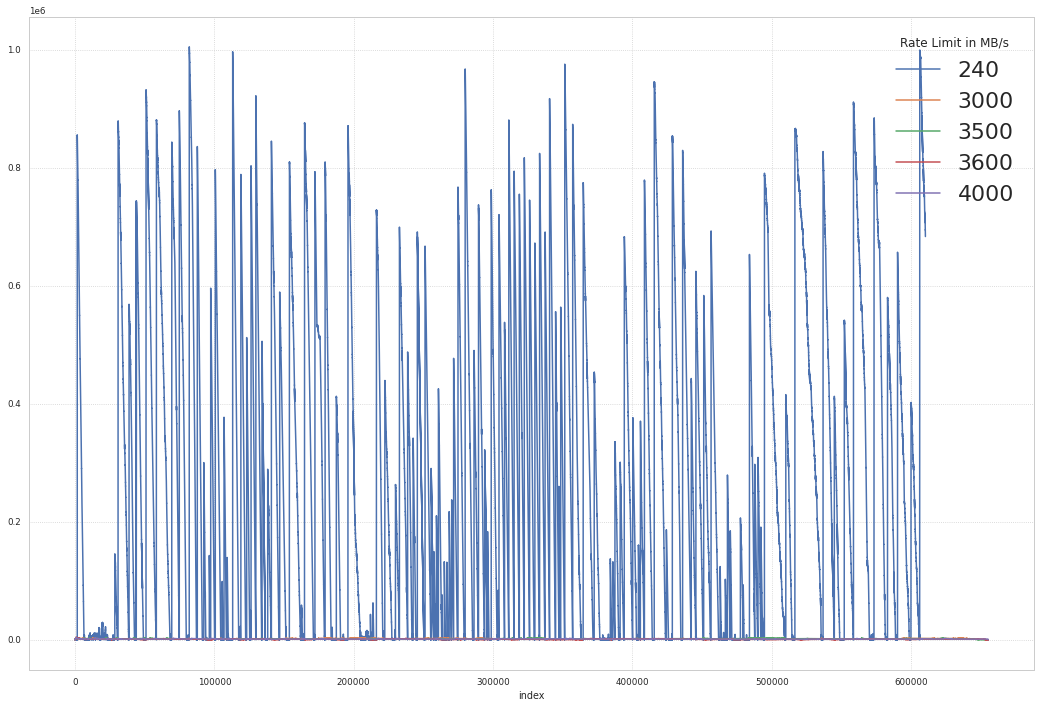

In [46]:
plot_timeseries(max_event_lat_df, "Latency in us")

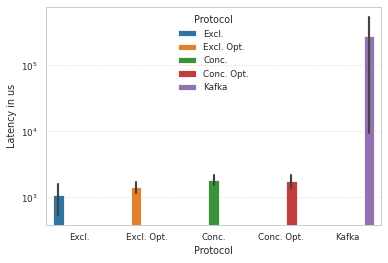

In [18]:
sns.set_context('paper')
sns.set_style('whitegrid', {'grid.linestyle': 'dotted'})
sns.despine(left=True)
g = sns.barplot(x="Protocol", y="Latency in us", hue="Protocol", data=max_event_lat_df, ci="sd")
g.set(yscale="log")
g.get_figure().savefig("ghostwriter_event_latency_100", bbox_inches="tight", dpi=600)

# Different Load Factors

In [21]:
dataframes_75 = producer_dfs(log_directory + "20200727/processing_latency/75/")

In [22]:
def prepare_dfs(dataframes, measure):
    df_list = [dataframes["exclusive"][measure],
               dataframes["exclusive_opt"][measure],
               dataframes["concurrent"][measure],
               dataframes["concurrent_opt/10"][measure],
               dataframes["kafka"][measure]]
    df_list[0]["Protocol"] = "Excl."
    df_list[1]["Protocol"] = "Excl. Opt."
    df_list[2]["Protocol"] = "Conc."
    df_list[3]["Protocol"] = "Conc. Opt."
    df_list[4]["Protocol"] = "Kafka"
    return pd.concat(df_list)

In [23]:
event_lat_75_df = prepare_dfs(dataframes_75, "event")

In [24]:
def prepare_plottable(measure):
    df_100 = filter_dfs(producer_dfs(log_directory + "20200727/processing_latency/"), measure)
    df_75 = prepare_dfs(producer_dfs(log_directory + "20200727/processing_latency/75/"), measure)
    df_50 = prepare_dfs(producer_dfs(log_directory + "20200727/processing_latency/50/"), measure)
    df_100["Load Factor"] = "100%"
    df_75["Load Factor"] = "75%"
    df_50["Load Factor"] = "50%"
    return pd.concat([df_100, df_75, df_50])

In [25]:
event_lat_df = prepare_plottable("event")

<ipython-input-15-85779e0d3f1d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_list[0]["Protocol"] = "Excl."
<ipython-input-15-85779e0d3f1d>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_list[1]["Protocol"] = "Excl. Opt."
<ipython-input-15-85779e0d3f1d>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

In [26]:
event_lat_df.groupby(["Load Factor", "Protocol"]).mean()

index  Latency in us  Message Size  # of Segments  \
Load Factor Protocol                                                           
100%        Conc.       327679.5    1852.160345      131072.0           90.0   
            Conc. Opt.  327679.5    1776.121205      131072.0           90.0   
            Excl.       327679.5    1064.759038      131072.0           90.0   
            Excl. Opt.  327679.5    1447.829659      131072.0           90.0   
            Kafka       305175.0  277205.739673      131072.0            NaN   
50%         Conc.       327679.5      70.563289      131072.0           90.0   
            Conc. Opt.  327679.5      63.978552      131072.0           90.0   
            Excl.       327679.5      61.949524      131072.0           90.0   
            Excl. Opt.  327679.5      55.162549      131072.0           90.0   
            Kafka       305175.0     805.766005      131072.0            NaN   
75%         Conc.       327679.5      78.126143      131072.0           90.0   
            Conc. Opt.  327679.5      65.810298      131072.0           90.0   
            Excl.       327679.5      67.432770      131072.0           90.0   
            Excl. Opt.  327679.5      54.716484      131072.0           90.0   
            Kafka       305175.0    2821.219457      131072.0            NaN   

                        Rate Limit in MB/s  
Load Factor Protocol                        
100%        Conc.                   3000.0  
            Conc. Opt.              3500.0  
            Excl.                   3600.0  
            Excl. Opt.              4000.0  
            Kafka                    240.0  
50%         Conc.                   1500.0  
            Conc. Opt.              1750.0  
            Excl.                   1800.0  
            Excl. Opt.              2000.0  
            Kafka                    120.0  
75%         Conc.                   2250.0  
            Conc. Opt.              2625.0  
            Excl.                   2700.0  
            Excl. Opt.              3000.0  
            Kafka                    180.0

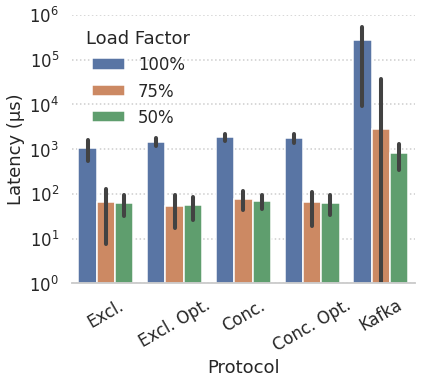

In [27]:
g = sns.catplot(x="Protocol", y="Latency in us", hue="Load Factor", data=event_lat_df, ci="sd", kind="bar",aspect=4./3, legend_out=False)
sns.despine(left=True)
g.set(yscale="log")
for ax in g.axes.flat:
    ax.set_yticks([1, 10, 100, 1000, 10000, 100000, 1000000])
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, horizontalalignment='center')
    ax.set_ylabel("Latency (μs)")
g.savefig("publishing_event_latency.pdf", bbox_inches="tight", dpi=600)

<ipython-input-15-85779e0d3f1d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_list[0]["Protocol"] = "Excl."
<ipython-input-15-85779e0d3f1d>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_list[1]["Protocol"] = "Excl. Opt."
<ipython-input-15-85779e0d3f1d>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

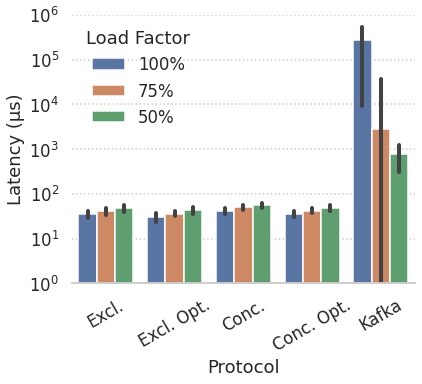

In [28]:
processing_lat_df = prepare_plottable("processing")
g = sns.catplot(x="Protocol", y="Latency in us", hue="Load Factor", data=processing_lat_df, ci="sd", kind="bar",aspect=4./3, legend_out=False)
sns.despine(left=True)
g.set(yscale="log")
for ax in g.axes.flat:
    ax.set_yticks([1, 10, 100, 1000, 10000, 100000, 1000000])
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, horizontalalignment='center')
    ax.set_ylabel("Latency (μs)")
g.savefig("publishing_processing_latency.pdf", bbox_inches="tight", dpi=600)

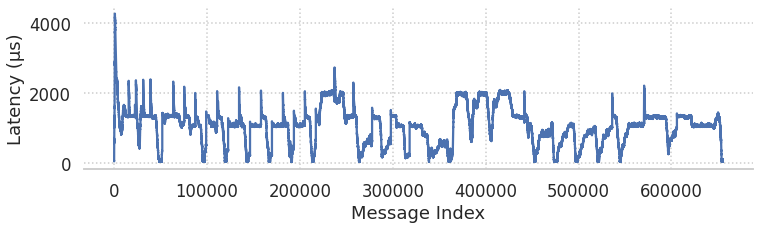

In [29]:
fig_dims = (12, 3)
fig, ax = plt.subplots(figsize=fig_dims)
# sns.set(font_scale=2)
sns.despine(left=True)
# df = dataframes["exclusive"]["processing"][dataframes["exclusive"]["processing"]["Rate Limit in MB/s"] == 3600].pivot(index='index', columns='Rate Limit in MB/s', values="Avg. Latency in us")
df = event_lat_df[event_lat_df["Load Factor"] == "100%"]
df = df[df["Protocol"] == "Excl."]
ax.plot(df["index"], df["Latency in us"])
ax.set_ylabel("Latency (μs)")
ax.set_xlabel("Message Index")
plt.savefig("exclusive_100_event_timeline.pdf", bbox_inches="tight", dpi=600)

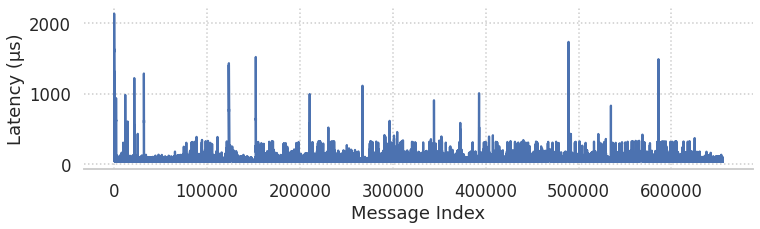

In [30]:
fig_dims = (12, 3)
fig, ax = plt.subplots(figsize=fig_dims)
# sns.set(font_scale=2)
sns.despine(left=True)
# df = dataframes["exclusive"]["processing"][dataframes["exclusive"]["processing"]["Rate Limit in MB/s"] == 3600].pivot(index='index', columns='Rate Limit in MB/s', values="Avg. Latency in us")
df = event_lat_df[event_lat_df["Load Factor"] == "75%"]
df = df[df["Protocol"] == "Excl."]
ax.plot(df["index"], df["Latency in us"])
ax.set_ylabel("Latency (μs)")
ax.set_xlabel("Message Index")
plt.savefig("exclusive_75_event_timeline.pdf", bbox_inches="tight", dpi=600)

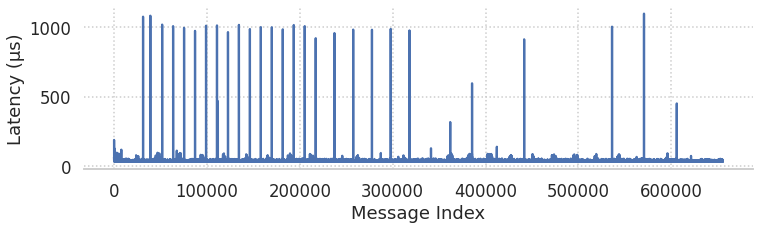

In [31]:
fig_dims = (12, 3)
fig, ax = plt.subplots(figsize=fig_dims)
# sns.set(font_scale=2)
sns.despine(left=True)
# df = dataframes["exclusive"]["processing"][dataframes["exclusive"]["processing"]["Rate Limit in MB/s"] == 3600].pivot(index='index', columns='Rate Limit in MB/s', values="Avg. Latency in us")
df = processing_lat_df[processing_lat_df["Load Factor"] == "100%"]
df = df[df["Protocol"] == "Excl."]
ax.plot(df["index"], df["Latency in us"])
ax.set_ylabel("Latency (μs)")
ax.set_xlabel("Message Index")
plt.savefig("exclusive_100_processing_timeline.pdf", bbox_inches="tight", dpi=600)

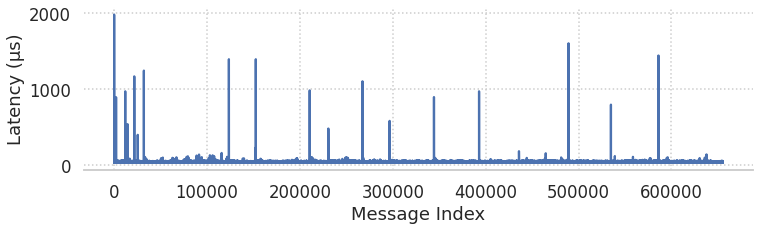

In [32]:
fig_dims = (12, 3)
fig, ax = plt.subplots(figsize=fig_dims)
# sns.set(font_scale=2)
sns.despine(left=True)
# df = dataframes["exclusive"]["processing"][dataframes["exclusive"]["processing"]["Rate Limit in MB/s"] == 3600].pivot(index='index', columns='Rate Limit in MB/s', values="Avg. Latency in us")
df = processing_lat_df[processing_lat_df["Load Factor"] == "75%"]
df = df[df["Protocol"] == "Excl."]
ax.plot(df["index"], df["Latency in us"])
ax.set_ylabel("Latency (μs)")
ax.set_xlabel("Message Index")
plt.savefig("exclusive_75_processing_timeline.pdf", bbox_inches="tight", dpi=600)

In [40]:
def plot_histogram(dataframe):
#     fig_dims = (18, 12)
    fig, ax = plt.subplots()
#     sns.set(font_scale=2)
    sns.set_context('poster')
    sns.set_style('whitegrid', {'grid.linestyle': 'dotted'})
    sns.despine(left=True)
    g = sns.lineplot(x="Message Size in Bytes", y="Throughput in MB/s", data=dataframe, ax=ax,ci="sd")
    g.set_xlabel("Message Size")
    ax.set_xscale('log')
    g.set_xticks([8192, 16384, 32768, 65536, 131072, 262144, 524288, 1048576, 2097152, 4194304, 8388608])
    g.set_xticklabels(['8K','16K','32K','64K','128K','256K','512K','1M', '2M', '4M', '8M'])
    plt.xticks(fontsize=20, rotation=45)
    plt.yticks(fontsize=20)

In [63]:
def plot_comp_histogram(exclusive_df, exclusive_opt_df, measure, filename):
    exclusive_df["Broker"] = "Naive"
    exclusive_opt_df["Broker"] = "Optimized"
    df = pd.concat([exclusive_df, exclusive_opt_df])
    fig, ax = plt.subplots()
    sns.set_context('paper')
    sns.set_style('whitegrid', {'grid.linestyle': 'dotted'})
    sns.despine(left=True)
    g = sns.lineplot(x="Message Size in Bytes", y=measure, hue="Broker", data=df, ax=ax,ci="sd")
    g.set_xlabel("Message Size")
    g.set_ylabel("Avg. " + measure)
    ax.set_xscale('log')
    g.set_xticks([8192, 16384, 32768, 65536, 131072, 262144, 524288, 1048576, 2097152, 4194304, 8388608])
    g.set_xticklabels(['8K','16K','32K','64K','128K','256K','512K','1M', '2M', '4M', '8M'])
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles[1:], labels=labels[1:])
    plt.xticks(rotation=45)
#     plt.yticks(fontsize=20)
    fig.savefig(filename, bbox_inches="tight", dpi=600)

# Consumer Latency

In [33]:
def create_rembrandt_consumer_dataframe(log_files, skiprows=0):
    joined_df = pd.DataFrame()
    for data_size, filename in log_files:
        df  = pd.read_csv(filename, sep='\t', skiprows=skiprows)
        df.reset_index(inplace=True)
        df["Message Size in Bytes"] = int(data_size)
        joined_df = pd.concat([joined_df, df])
    return joined_df

In [34]:
def consumer_dfs(directory):
    result = {}
    for variant in ["exclusive", "exclusive_opt", "concurrent", "concurrent_opt"]:
        variant_dfs = {}
        variant_dfs["tp"] = create_rembrandt_consumer_dataframe(get_consumer_files(directory + variant, "rembrandt_consumer_(\d+)_throughput.csv"))
        variant_dfs["latency"] = create_rembrandt_consumer_dataframe(get_consumer_files(directory + variant, "rembrandt_consumer_(\d+)_latency_timeline.csv"), skiprows=1)
        result[variant] = variant_dfs
    
    kafka_dfs = {}
    kafka_dfs["tp"] = create_rembrandt_consumer_dataframe(get_consumer_files(directory + "kafka", "kafka_consumer_(\d+)_throughput.csv"))
    kafka_dfs["latency"] = create_rembrandt_consumer_dataframe(get_consumer_files(directory + "kafka", "kafka_consumer_(\d+)_processing_latency_timeline.csv"), skiprows=1)
    result["kafka"] = kafka_dfs
    return result

In [35]:
cons_dfs = consumer_dfs(log_directory + "20200727/processing_latency/")

In [36]:
def prepare_dfs(dataframes, measure):
    df_list = [dataframes["exclusive"][measure],
               dataframes["exclusive_opt"][measure],
               dataframes["concurrent"][measure],
               dataframes["concurrent_opt"][measure],
               dataframes["kafka"][measure]]
    df_list[0]["Protocol"] = "Excl."
    df_list[1]["Protocol"] = "Excl. Opt."
    df_list[2]["Protocol"] = "Conc."
    df_list[3]["Protocol"] = "Conc. Opt."
    df_list[4]["Protocol"] = "Kafka"
    return pd.concat(df_list)

In [37]:
cons_df = prepare_dfs(cons_dfs, "latency")

In [38]:
cons_df.tail()

,index,Latency in us,Message Size in Bytes,Protocol
610346,610346,505,131072,Kafka
610347,610347,548,131072,Kafka
610348,610348,535,131072,Kafka
610349,610349,534,131072,Kafka
610350,610350,726,131072,Kafka


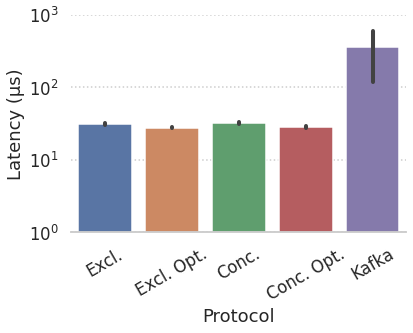

In [39]:
sns.despine(left=True)
g = sns.barplot(x="Protocol", y="Latency in us", hue="Protocol", data=cons_df, ci="sd", dodge=False)
sns.despine(left=True)
g.get_legend().remove()
g.set_xticklabels(g.get_xticklabels(), rotation=30, horizontalalignment='center')
g.set_ylabel("Latency (μs)")
plt.yscale("log")
g.set_yticks([1, 10, 100, 1000])
g.get_figure().savefig("consumer_latency.pdf", bbox_inches="tight", dpi=600)